In [ ]:
# default_exp measures

# Measures

> Compute behavioural measures from raw transaction data

## Overview

A behavioural measure is a number derived from a player's transaction data. This data needs to have specific columns depending on the measure you want to calculate. For example, measures in the bet domain require the **bet_size** column. For each of the measures you plan to use, make sure that the data you have in the gamba standard format (see `check_data`) has the correct values.

Once your data has all of the right columns, the simplest way to get started is to call the `create_measures_table` method below, giving it one or more players bets in the gamba standard format.

In [9]:
#export
import pandas as pd
def create_measures_table(all_player_bets, measures, daily=False):
    "Creates a measures table from a collection of bets in the gamba standard format. The second parameter 'measures' should be a list of names from the measures module. See `available_measures` or the table below for currently available options."
    
    # get unique players
    unique_players = list(set(all_player_bets['player_id'].values))
    
    # create holding structure for each of the measures
    measures_table_values = [unique_players]
    

    # for each of the measures
    for measure in measures:
        all_players_measures = []
        
        # for each of the players
        for player in unique_players:
            
            player_bets = all_player_bets[all_player_bets['player_id'] == player]
            # compute and add to holding structure
            this_measure = eval(measure + '(player_bets)')
            
            all_players_measures.append(this_measure)
            
        measures_table_values.append(all_players_measures)
    
    # turn into tidy dataframe
    measures_table = pd.DataFrame()
    measures_table['player_id'] = unique_players
    for x, measure in enumerate(measures):
        measures_table[measure] = measures_table_values[x + 1]
    
    return measures_table

> Note: The `create_measures_table` method is perhaps the most useful thing in the entire library.

## Behavioural Measures

Not all measures need the same data to be computed. The gamba library distinguishes between three primary domains (time, cost, and loss), and includes a final *other* domain to include everything else.

| **Time**                       | **Cost**                               | **Loss**                      | **Other**                 |
|--------------------------------|----------------------------------------|-------------------------------|---------------------------|
| `duration`                     | `total_wagered`                        | `net_loss`                    | `theoretical_loss`        |
| `frequency`                    | `mean_bet_size`                        | `percent_loss`                | `mean_odds_per_bet`       |
| `frequency_percent`            | `median_bet_size`                      | `payout_bet_count_ratio`      | `median_odds_per_bet`     |
| `number_of_bets`               | `max_bet`                              | `payout_bet_size_ratio`       | `num_providers_used`      |
| `mean_bets_per_day`            | `min_bet`                              | `mean_net_loss_per_session`   | `mean_game_types_per_day` |
| `median_bets_per_day`          | `bet_size_range`                       | `median_net_loss_per_session` |                           |
| `num_sessions`                 | `bet_size_deviation`                   | `sum_of_payouts`              |                           |
| `total_play_time`              | `trajectory`                           | `relative_big_win`            |                           |
| `mean_sessions_per_day`        | `mean_amount_wagered_per_day`          | `big_win`                     |                           |
| `median_sessions_per_day`      | `median_amount_wagered_per_day`        | `mean_payout_size`            |                           |
| `mean_play_time`               | `amount_wagered_per_day_variance`      | `median_payout_size`          |                           |
| `median_play_time`             | `mean_amount_wagered_per_session`      | `overall_binary_loser`        |                           |
| `mean_bets_per_day_aggregated` | `median_amount_wagered_per_session`    | `clamped_net_win`             |                           |
| `median_bets_per_day`          | `total_amount_wagered_across_duration` | `net_loss_on_last_day`        |                           |
| `num_bets_deviation_per_day`   | `amount_wagered_per_session_variance`  | `mean_loss_per_bet`           |                           |
| `inactive_day_streak_variance` | `bet_size_trajectory`                  | `median_loss_per_bet`         |                           |
| `persistence`                  |                                        |                               |                           |
| `bet_count_trajectory`         |                                        |                               |                           |
| `mean_bets_per_session`        |                                        |                               |                           |
| `median_bets_per_session`      |                                        |                               |                           |
| `bets_per_session_variance`    |                                        |                               |                           |
| `session_duration_variance`    |                                        |                               |                           |
| `session_duration_trajectory`  |                                        |                               |                           |
| `sawtooth_occurances`          |                                        |                               |                           |
| `active_day_trajectory`        |                                        |                               |                           |

### Time Domain

The time domain consists of behavioural measures that can be computed using only the knowledge of when the bets took place. This means using only values from the ***bet_time*** column in the player bet dataframe.

In [ ]:
#export
def duration(player_bets):
    "The number of days between the first bet and the last."
    check_measure_data(player_bets, ["bet_time"])
    player_bets.sort_values("bet_time", inplace=True)
    player_bets.reset_index(drop=True, inplace=True)

    first_day = player_bets.iloc[0]["bet_time"]
    last_day = player_bets.iloc[len(player_bets) - 1]["bet_time"]
    # add one to make it interpret as 'days where betting has occurred'
    age_in_days = (last_day.date() - first_day.date()).days + 1
    return age_in_days

In [ ]:
#export
def frequency(player_bets):
    "The number of days that included at least one bet. Note that this method returns the raw number of days."
    check_measure_data(player_bets, ["bet_time"])
    
    player_bets.sort_values("bet_time", inplace=True)
    player_bets.reset_index(drop=True, inplace=True)

    betting_dates = player_bets["bet_time"].dt.date

    return len(betting_dates.unique())

def frequency_aggregated(player_bets):
    "Number of active betting days in first month, if data set contains daily aggregate data."
    
    first_day = player_bets.iloc[0]["bet_time"]
    one_month_later = first_day + datetime.timedelta(days=+30)
    first_month_bets = player_bets[player_bets["bet_time"] <= one_month_later]

    return len(first_month_bets)

In [ ]:
#export
def frequency_percent(player_bets):
    "The percentage of days within the `duration` that included at least one bet. Note that this method returns the actual percentage value e.g. 75, **not** the raw number of days or values in the interval [0,1]."
    check_measure_data(player_bets, ["bet_time"])
    player_bets.sort_values("bet_time", inplace=True)
    player_bets.reset_index(drop=True, inplace=True)
    age_in_days = duration(player_bets)

    betting_dates = player_bets["bet_time"].dt.date
    first_day = player_bets.iloc[0]["bet_time"]

    betting_days = 0
    for day in range(age_in_days):
        current_date = (first_day + datetime.timedelta(days=day)).date()
        bets_today = player_bets.iloc[betting_dates.values == current_date]
        if len(bets_today) != 0:
            betting_days += 1

    frequency_percentage = (betting_days / age_in_days) * 100
    return frequency_percentage

In [ ]:
#export
def number_of_bets(player_bets, daily=False):
    "The total number of bets made."

    if daily:        
        check_measure_data(player_bets, ["bet_count"])
        return player_bets["bet_count"].sum()
    
    return len(player_bets)

In [ ]:
#export
def mean_bets_per_day_aggregated(player_bets):
    "Mean number of bets per active betting day in first month (intensity), if data set contains daily aggregate data."

    first_day = player_bets.iloc[0]["bet_time"]
    one_month_later = first_day + datetime.timedelta(days=+30)
    first_month_bets = player_bets[player_bets["bet_time"] <= one_month_later]
    result = first_month_bets["bet_count"].mean()
    return result

def mean_bets_per_day(player_bets):
    days = get_daily_bets(player_bets)
    daily_counts = [len(day) for day in days]
    return np.mean(daily_counts)

def median_bets_per_day(player_bets):
    days = get_daily_bets(player_bets)
    daily_counts = [len(day) for day in days]
    return np.median(daily_counts)

In [ ]:
#export
def num_sessions(player_bets, session_window=20):
    "The number of gambling sessions a player played, where a session is a sequence of bets each within some time (session_window) of the previous bet."
    
    # no need to check_measure_data here as it's done in get_sessions
    sessions = get_sessions(player_bets, session_window=session_window)
    
    return len(sessions)

In [2]:
#export
import datetime
def total_play_time(player_bets, session_window=20):
    "The sum of all session lengths."
    # first used by Fiedler 2011
    
    # no need to check_measure_data here as it's done in get_sessions
    sessions = get_sessions(player_bets, session_window=session_window)
    
    play_time = datetime.timedelta(0)
    for session in sessions:
        start = session['bet_time'].min()
        end = session['bet_time'].max()
        session_length = end - start
    
        play_time += session_length
    
    return play_time

In [ ]:
#export
def mean_sessions_per_day(player_bets):
    daily_bets = get_daily_bets(player_bets)
    
    sessions_per_day = []
    for day in daily_bets:
        sessions = get_sessions(day)
        sessions_per_day.append(len(sessions))
    
    return np.mean(sessions_per_day)
    

def median_sessions_per_day(player_bets):
    daily_bets = get_daily_bets(player_bets)
    
    sessions_per_day = []
    for day in daily_bets:
        sessions = get_sessions(day)
        sessions_per_day.append(len(sessions))
    
    return np.median(sessions_per_day)

In [ ]:
#export
import numpy as np
def mean_session_duration(player_bets):
    sessions = get_sessions(player_bets)
    session_durations = [session['bet_time'].max() - session['bet_time'].min() for session in sessions]
    return np.mean(session_durations)

def median_session_duration(player_bets):
    sessions = get_sessions(player_bets)
    session_durations = [session['bet_time'].max() - session['bet_time'].min() for session in sessions]
    return np.median(session_durations)

In [5]:
#export
import numpy as np

def mean_play_time(player_bets):
    # Computes total play time per day (UTC), returning the mean of those values.
    tpt = total_play_time(player_bets)
    dur = duration(player_bets)    
    return tpt/dur

def median_play_time(player_bets):
    # Computes total play time per day (UTC), returning the median of those values.
    daily_bets = get_daily_bets(player_bets)
    daily_play_times = [total_play_time(bets) for bets in daily_bets]
    return np.median(daily_play_times)

In [4]:
#export
import numpy as np
def median_bets_per_day(player_bets):
    "Aggregates daily bets and returns the median number of bets placed across all active betting days."
    
    daily_bets = aggregate_bets(player_bets, aggregation='daily')
    
    daily_bet_count = [len(bets) for bets in daily_bets]
    
    return np.median(daily_bet_count)

In [ ]:
#export
import numpy as np
def num_bets_deviation_per_day(player_bets):
    "Standard deviation of the number of bets placed per active betting day."
    # used in Braverman and Shaffer 2013
    
    daily_bets = aggregate_bets(player_bets, aggregation='daily')
    
    daily_bet_count = [len(bets) for bets in daily_bets]
    
    return np.std(daily_bet_count)

In [ ]:
#export
from datetime import timedelta
import numpy as np
from pysan.spells import get_spells

def inactive_day_streak_variance(player_bets):
    
    betting_days = betting_days.dt.date
    
    active_dates = betting_days.unique()
    
    all_days = pd.date_range(betting_days.min(), betting_days.max(), freq='d')    
    
    all_days_as_sequence_with_active_as_true = [True if (date in active_dates) else False for date in all_days]    
    
    # the day-streak data can be framed as spells in sequence analysis for easy extraction
    spells = get_spells(all_days_as_sequence_with_active_as_true)    
    inactive_spells = [spell for spell in spells if (spell[0] == False)]    
    inactive_spell_lengths = [spell[1] for spell in inactive_spells]
        
    return np.var(inactive_spell_lengths)

In [ ]:
#export
from datetime import timedelta
import numpy as np
from pysan.spells import get_spells

def persistence(player_bets):
    
    active_months = player_bets['bet_time'].dt.to_period("M").unique()
    
    # use daily frequency then to_period to catch full period (rather than cut off part of last month)
    all_months = pd.date_range(player_bets['bet_time'].min(), player_bets['bet_time'].max(), freq='d').to_period("M").unique()
        
    all_months_as_sequence_with_active_as_true = [True if (month in active_months) else False for month in all_months]
    
    # the day-streak data can be framed as spells in sequence analysis for easy extraction
    spells = get_spells(all_months_as_sequence_with_active_as_true)
    active_month_spells = [spell[1] for spell in spells if spell[0] == True] # true is active month
    
    return max(active_month_spells)

In [ ]:
#export
def bet_count_trajectory(player_bets):
    days = get_daily_bets(player_bets)
    daily_counts = [len(bets) for bets in days]
    return generic_trajectory(daily_counts)

In [ ]:
#export
def mean_bets_per_session(player_bets):
    sessions = get_sessions(player_bets)
    
    return np.mean([len(session) for session in sessions])

def median_bets_per_session(player_bets):
    sessions = get_sessions(player_bets)
    
    return np.median([len(session) for session in sessions])

def bets_per_session_variance(player_bets):
    sessions = get_sessions(player_bets)
    
    return np.var([len(session) for session in sessions])

In [ ]:
#export
def session_duration_variance(player_bets):
    sessions = get_sessions(player_bets)
    session_durations = [session['bet_time'].max() - session['bet_time'].min() for session in sessions]
    return np.var(session_durations)

def session_duration_trajectory(player_bets):
    sessions = get_sessions(player_bets)
    session_durations = [session['bet_time'].max() - session['bet_time'].min() for session in sessions]
    return generic_trajectory(session_durations)

In [ ]:
#export
def sawtooth_occurances(player_bets, threshold=1):
    
    # this algorithm is described on page 8 of Adami et al's 2013 paper
    # the threshold parameter is not well defined so defaults to 1 but is
    # changeable, and ultimately determines whether or not a change in
    # bet sizing constitutes a sawtooth occurance
    
    first_difference = player_bets['bet_size'].diff()
    
    mean = first_difference.mean()
    std = first_difference.std()    
    
    #                                                      here is the formula from the paper
    occurances = [1 for difference in first_difference if difference > mean + threshold * std]
    
    return len(occurances)

In [ ]:
#export
import datetime

def active_day_trajectory(player_bets, time_period_length=datetime.timedelta(days=30)):
    
    midpoint = player_bets['bet_time'].min() + time_period_length
    endpoint = midpoint + time_period_length
    
    first_period = player_bets[player_bets['bet_time'] < midpoint]
    second_period = player_bets[player_bets['bet_time'].between(midpoint, endpoint)]
    
    f1 = frequency(first_period) # aka number of active days
    f2 = frequency(second_period)
    
    return generic_trajectory([f1,f2])

### Cost Domain

The cost domain contains all behavioural measures which can be computed using additional values from the ***bet_size*** column. As such, they describe *spending* behaviours as opposed to *engagement* behaviours as above.

In [ ]:
#export
def total_wagered(player_bets):
    "The total amount wagered (sum of bet sizes)."
    check_measure_data(player_bets, ["bet_size"])
    return player_bets["bet_size"].sum()

In [ ]:
#export
def mean_bet_size(player_bets, daily=False):
    "The average (mean) size of bets."
    if daily:
        check_measure_data(player_bets, ["bet_size"])
        mean_bet_size = player_bets["bet_size"].sum() / number_of_bets(player_bets, daily=True)
        return mean_bet_size
        
    check_measure_data(player_bets, ["bet_size"])
    return player_bets["bet_size"].mean()

In [4]:
#export
def median_bet_size(player_bets):
    "Median bet size, as used in Xuan 2009"
    
    check_measures_data(player_bets, ['bet_size'])
    
    return player_bets['bet_size'].median()

In [ ]:
#export
def max_bet(player_bets):
    return player_bets['value'].max()

def min_bet(player_bets):
    return player_bets['value'].min()

def bet_size_range(player_bets):
    return max_bet(player_bets) - min_bet(player_bets)

In [ ]:
#export
def bet_size_deviation(player_bets, daily=False):
    "Standard deviation of stake size in first month, if data set contains daily aggregate data."
    
    if daily:
        first_day = player_bets.iloc[0]["bet_time"]
        one_month_later = first_day + datetime.timedelta(days=+30)
        first_month_bets = player_bets[player_bets["bet_time"] <= one_month_later]

        return first_month_bets["bet_size"].std()
    
    return player_bets["bet_size"].std()

In [ ]:
#export
from sklearn.linear_model import LinearRegression
import numpy as np
def trajectory(player_bets, daily=False, plot=False):
    "Gradient of a linear regression fitted to the sequence of daily aggredated bet sizes."
    
    if daily:
        first_day = player_bets.iloc[0]["bet_time"]
        one_month_later = first_day + datetime.timedelta(days=+30)
        first_month_bets = player_bets[player_bets["bet_time"] <= one_month_later]

        # first_month_bets['mean_bet_size'] = first_month_bets['bet_size'] / first_month_bets['bet_count']

        x = np.array(range(len(first_month_bets))).reshape((-1, 1)) + 1
        y = first_month_bets["bet_size"].values

        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)

        model_x = x
        model_y = model.coef_ * x + model.intercept_

        if plot:
            plt.figure()
            plt.scatter(x, y)
            plt.plot(model_x, model_y, color="r")
            plt.show()

        trajectory = model.coef_[0]
        return model.coef_[0]

In [1]:
#export
def mean_amount_wagered_per_day(player_bets):
    return total_amount_wagered(player_bets) / frequency(player_bets)

def median_amount_wagered_per_day(player_bets):
   
    daily_bets = get_daily_bets(player_bets)
    
    tam_daily = [total_amount_wagered(daily) for daily in daily_bets]
    
    return np.median(tam_daily)

In [ ]:
#export
def amount_wagered_per_day_variance(player_bets):
    
    daily_bets = get_daily_bets(player_bets)
    
    tam_daily = [total_amount_wagered(daily) for daily in daily_bets]
    
    return np.var(tam_daily)

In [2]:
#export
import numpy as np
def mean_amount_wagered_per_session(player_bets):
    
    sessions = get_sessions(player_bets)
    tam_sessions = [total_amount_wagered(session) for session in sessions]
    return np.mean(tam_sessions)

def median_amount_wagered_per_session(player_bets):
    
    sessions = get_sessions(player_bets)
    tam_sessions = [total_amount_wagered(session) for session in sessions]
    return np.median(tam_sessions)

In [ ]:
#export
def total_amount_wagered_across_duration(player_bets):
    tam = total_amount_wagered(player_bets)
    dur = duration(player_bets)
    return tam/dur

In [ ]:
#export
def amount_wagered_per_session_variance(player_bets):
    sessions = get_sessions(player_bets)
    tam_sessions = [total_amount_wagered(session) for session in sessions]
    return np.var(tam_sessions)

In [ ]:
#export
def bet_size_trajectory(player_bets):
    days = get_daily_bets(player_bets)
    daily_sizes = [bets["bet_size"].sum() for bets in days]
    return generic_trajectory(daily_sizes)

### Loss Domain

The loss domain includes all behavioural measures which require the additional information of the size of the payout received as a result of each bet. This data should be held in the ***payout_size*** column if available.

In [ ]:
#export
def net_loss(player_bets):
    "The net amount lost (sum of bet sizes minus sum of payout sizes). This is functionally identical to the negative of total amount won"
    
    check_measure_data(player_bets, ["bet_size", "payout_size"])
    net_loss_value = player_bets["bet_size"].sum() - player_bets["payout_size"].sum()
    return net_loss_value

In [ ]:
#export
def percent_loss(player_bets):
    "The `net_loss` as a percentage of `total_wagered`."

    net_loss_value = net_loss(player_bets)
    total_wagered_value = total_wagered(player_bets)
    percent_loss_value = (net_loss_value / total_wagered_value) * 100
    return percent_loss_value

In [ ]:
#export
def payout_bet_count_ratio(player_bets):
    bets = len(player_bets)
    payouts = len(player_bets[player_bets['payout_size'] != 0])
    return payouts / bets

def payout_bet_size_ratio(player_bets):
    bets = player_bets['bet_size'].sum()
    payouts = player_bets['payout_size'].sum()
    return payouts / bets

In [ ]:
#export
def mean_net_loss_per_session(player_bets):
    
    sessions = get_sessions(player_bets)
    nl_sessions = [net_loss(session) for session in sessions]
    return np.mean(nl_sessions)

def median_net_loss_per_session(player_bets):
    
    sessions = get_sessions(player_bets)
    nl_sessions = [net_loss(session) for session in sessions]
    return np.median(nl_sessions)

In [ ]:
#export
def sum_of_payouts(player_bets):
    return player_bets['payout_size'].sum()

def relative_big_win(player_bets, top):
    return 1 if max(player_bets['payout_size'] > top) else 0

def big_win(player_bets):
    # assumes payout_size is in USD already(!)
    return 1 if max(player_bets['payout_size'] > 1000) else 0

In [ ]:
#export
def mean_payout_size(player_bets):
    payouts = player_bets[player_bets['payout_size'] != 0]
    return payouts['payout_size'].mean()

def median_payout_size(player_bets):
    payouts = player_bets[player_bets['payout_size'] != 0]
    return payouts['payout_size'].median()

In [ ]:
#export
def overall_binary_loser(player_bets):
    return 1 if net_loss(player_bets) > 0 else 1

def clamped_net_win(player_bets):
    return max(-net_loss(player_bets), 0)

def net_loss_on_last_day(player_bets):
    days = get_daily_bets(player_bets)
    last_day = days[-1]
    return net_loss(last_day)

In [1]:
#export
def mean_loss_per_bet(player_bets):
    # additional measure not returned by literature review
    "The median amount lost per bet (bet size minus payout)."
    
    losses = player_bets['bet_size'] - player_bets['payout_size']
    
    return losses.mean()


def median_loss_per_bet(player_bets):
    # additional measure not returned by literature review
    "The median amount lost per bet (bet size minus payout)."
    
    losses = player_bets['bet_size'] - player_bets['payout_size']
    
    return losses.median()

### Other Domain

All measures not in the root, bet, or loss domains, require some additional information such as the house edge for each bet, the game being played, etc. These are currently broadly grouped into the 'other' domain' but as the library (and academic)'s capabilities grow, this domain will likely be split further.

In [ ]:
#export
def theoretical_loss(player_bets):
    "The product of bet size and house advantage, also referred to as the gross gaming revenue."
    
    check_measure_data(player_bets, ['bet_size','house_edge'])
    
    unique_edges = player_bets['house_edge'].unique()
    
    tl_measure = 0
    for edge in unique_edges:
        bets_with_this_edge = player_bets[player_bets['house_edge'] == edge]
        
        tl_measure += bets_with_this_edge['bet_size'].sum() * (edge / 100)
    
    return tl_measure

In [3]:
#export
def mean_odds_per_bet(player_bets):
    return player_bets['decimal_odds'].mean()

def median_odds_per_bet(player_bets):
    return player_bets['decimal_odds'].median()

In [6]:
#export
def num_providers_used(player_bets): # regarding operators, not game types
    # this measure is technically at the account-leve/
    "The number of different gambling game providers used by the player."
    
    check_measures_data(player_bets, ['provider'])
    
    return len(player_bets['provider'].unique())

In [10]:
#export
import numpy as np
def mean_game_types_per_day(player_bets):
    "The mean number of unique game types played per active betting day. Note this does not account for the number of each game type played, only that they have been played at least once."
    # this measure is also technically at the account level
    
    daily_bets = aggregate_bets(player_bets, aggregation='daily')
    
    daily_game_types = [len(bets['game_type'].unique()) for bets in daily_bets]
    
    return np.mean(daily_game_types)

## Study Collections

The measures module also contains some convenience methods which accept full existing data sets of players bets and compute the collection of behavioural measures used in a given study.

In [ ]:
#export
from tqdm import tqdm
import datetime, pandas as pd
def calculate_labrie_measures(all_player_bets, savedir="", filename="gamba_labrie_measures.csv", loud=False, daily=True,):
    "Calculates the set of measures described in LaBrie et al's work in 2008 on casino gamblers. These measures include the durations, frequencies, number of bets, bets per day, value per bet (eth), total amount wagered, net loss, and percent loss for each player. As this method sits in the studies module, it accepts a list of dataframes representing each player's bets as input. By default, this method saves the resulting dataframe of each player's measures to 'gamba_labrie_measures.csv'. Be advised: this method can take some time for large numbers of players, the 'loud' parameter can be set to True to print out updates every 200 players."

    pd.options.mode.chained_assignment = None # supress setwithcopy warnings
    
    player_id = []
    all_duration = []
    all_frequency = []
    all_number_of_bets = []
    all_mean_bets_per_day = []
    all_mean_bet_size = []
    all_total_wagered = []
    all_net_loss = []
    all_percent_loss = []

    unique_players = list(set(all_player_bets["player_id"]))

    for i in tqdm(range(len(unique_players))):
        player_bets = all_player_bets[all_player_bets["player_id"] == unique_players[i]]
        player_id.append(player_bets.iloc[0]["player_id"])
        all_duration.append(duration(player_bets))
        all_frequency.append(frequency(player_bets))
        if daily:
            all_number_of_bets.append(number_of_bets(player_bets, daily=True))
            all_mean_bets_per_day.append(mean_bets_per_day(player_bets, daily=True))
            all_mean_bet_size.append(mean_bet_size(player_bets, daily=True))
        else:
            all_number_of_bets.append(number_of_bets(player_bets))
            all_mean_bets_per_day.append(mean_bets_per_day(player_bets))
            all_mean_bet_size.append(mean_bet_size(player_bets))
        all_total_wagered.append(total_wagered(player_bets))
        all_net_loss.append(net_loss(player_bets))
        all_percent_loss.append(percent_loss(player_bets))

    labrie_dict = {
        "player_id": player_id,
        "duration": all_duration,
        "frequency": all_frequency,
        "num_bets": all_number_of_bets,
        "mean_bets_per_day": all_mean_bets_per_day,
        "mean_bet_size": all_mean_bet_size,
        "total_wagered": all_total_wagered,
        "net_loss": all_net_loss,
        "percent_loss": all_percent_loss,
    }

    labrie_measures = pd.DataFrame.from_dict(labrie_dict)
    labrie_measures.to_csv(savedir + filename, index=False)

    if loud:
        print("LaBrie measures saved")

    return labrie_measures

In [ ]:
#export
def calculate_braverman_measures(all_player_bets, savedir="", loud=False):
    "Calculates the set of measures described in Braverman and Shaffer's work in 2010 on high risk internet gamblers. These measures include the frequency, intensity, variability, and trajectories of each player. As this method sits in the studies module, it accepts a list of dataframes representing each player's bets as input. By default, this method saves the resulting dataframe of each player's measures to 'gamba_braverman_measures.csv'."

    pd.options.mode.chained_assignment = None # supress setwithcopy warnings
    
    player_id = []

    intensities = []
    variabilities = []
    frequencies = []
    trajectories = []

    sum_of_stakes = []
    total_num_bets = []
    mean_bet_sizes = []
    durations = []
    net_losses = []

    unique_players = list(set(all_player_bets["player_id"]))

    for i in tqdm(range(len(unique_players))):
        player_bets = all_player_bets[all_player_bets["player_id"] == unique_players[i]]

        player_id.append(player_bets.iloc[0]["player_id"])
        intensities.append(intensity(player_bets))
        frequencies.append(frequency(player_bets))
        variabilities.append(variability(player_bets, daily=True))
        trajectories.append(trajectory(player_bets, daily=True))

        sum_of_stakes.append(player_bets["bet_size"].sum())
        total_num_bets.append(player_bets["bet_count"].sum())
        mean_bet_sizes.append(
            player_bets["bet_size"].sum() / player_bets["bet_count"].sum()
        )
        durations.append(duration(player_bets))
        net_losses.append(net_loss(player_bets))

    braverman_dict = {
        "player_id": player_id,
        "intensity": intensities,
        "frequency": frequencies,
        "variability": variabilities,
        "trajectory": trajectories,
        "sum_of_stakes": sum_of_stakes,
        "total_num_bets": total_num_bets,
        "mean_bet_size": mean_bet_sizes,
        "duration": durations,
        "net_loss": net_losses,
    }

    braverman_measures = pd.DataFrame.from_dict(braverman_dict)
    braverman_measures.to_csv(savedir + "gamba_braverman_measures.csv", index=False)

    return braverman_measures

## Utility Functions

This module also contains a utility function for standardising each of the measures in a measures table, aggregating bets, checking measure data, and other things. It's unlikely that you'll need to use these methods directly in your own work, but are used in some of the higher-level methods in the library.

In [2]:
#export
def available_measures():
    "Returns a list of valid measures that the gamba library can compute. This list can be used in whole or in part by the `create_measures_table` method to compute these measures across one or more players bets."
    return ['duration','total_wagered','net_loss','theoretical_loss','frequency','mean_bet_size','percent_loss','mean_odds_per_bet','frequency_percent','median_bet_size','payout_bet_count_ratio','median_odds_per_bet','number_of_bets','max_bet','payout_bet_size_ratio','num_providers_used','mean_bets_per_day','min_bet','mean_net_loss_per_session','mean_game_types_per_day','median_bets_per_day','bet_size_range','median_net_loss_per_session','num_sessions','bet_size_deviation','sum_of_payouts','total_play_time','trajectory','relative_big_win','mean_sessions_per_day','mean_amount_wagered_per_day','big_win','median_sessions_per_day','median_amount_wagered_per_day','mean_payout_size','mean_play_time','amount_wagered_per_day_variance','median_payout_size','median_play_time','mean_amount_wagered_per_session','overall_binary_loser','mean_bets_per_day','median_amount_wagered_per_session','clamped_net_win','median_bets_per_day','total_amount_wagered_across_duration','net_loss_on_last_day','num_bets_deviation_per_day','amount_wagered_per_session_variance','mean_loss_per_bet','inactive_day_streak_variance','bet_size_trajectory','median_loss_per_bet','persistence','bet_count_trajectory','mean_bets_per_session','median_bets_per_session','bets_per_session_variance','session_duration_variance','session_duration_trajectory','sawtooth_occurances']

In [1]:
#export
def check_measure_data(player_bets, required_columns):
    "Compares the columns found in a dataframe of player bets to a supplied list of column names. If any of the required_column names are not found, an exception is raised reporting the error."
    
    for column in required_columns:
        if column not in player_bets.columns:
            exception_string = (
                "Column '" + column + "' missing from provided dataframe."
            )
            raise Exception(exception_string)

In [1]:
#export
import datetime
def get_sessions(player_bets, session_window=30):
    "Splits a single players bet dataframe into a collection of dataframes, each representing a single session. The session_window parameter determines the maximum number of minutes between bets for them to be considered part of the same session."
    check_measure_data(player_bets, ['bet_time'])
    
    elapsed_times = player_bets['bet_time'].diff()
    
    session_starts = [True if x> datetime.timedelta(minutes=session_window) else False for x in elapsed_times]
    
    session_ids = []
    current_session = 1
    for x in session_starts:
        if x:
            current_session += 1
        session_ids.append(current_session)
    
    player_bets['session_id'] = session_ids
    
    sessions = [x for _, x in player_bets.groupby(player_bets['session_id'])]
    
    return sessions

In [ ]:
#export
def get_daily_bets(player_bets):
    # split player bets into multiple dataframes, each corresponding to bets placed on a single active betting date (UTC)
    
    check_measure_data(player_bets, ["bet_time"])
    player_bets.sort_values("bet_time", inplace=True)
    player_bets.reset_index(drop=True, inplace=True)
    age_in_days = duration(player_bets)

    betting_days = player_bets["bet_time"].dt.date
    first_day = player_bets.iloc[0]["bet_time"]

    daily_bets = []
    for day in range(age_in_days):
        current_date = (first_day + datetime.timedelta(days=day)).date()
        bets_today = player_bets[betting_days == current_date]
        if len(bets_today) != 0:
            daily_bets.append(bets_today)
            
    return daily_bets

In [ ]:
#export
import scipy.stats
def standardise_measures_table(measures_table):
    "Standardises all measures columns in a measures table by applying the scipy.stats.zscore function to each column. This is useful for column-wise comparisons and some clustering methods, but use with caution!"

    colnames = list(measures_table.columns)[1:]

    standardised_table = pd.DataFrame()
    standardised_table["player_id"] = measures_table["player_id"].values
    for col in colnames:
        standardised_table[col] = scipy.stats.zscore(measures_table[col].values)

    return standardised_table

In [ ]:
#export
def split_measures_table(measures_table, frac=0.7, loud=False):
    "Splits a measures table into two randomly selected groups. This is useful for machine learning methods where a train-test split is needed, and uses the Pandas library's sample method."

    measures_table.drop(['player_id'], axis=1)
    train_table = measures_table.sample(frac=frac) 
    test_table = measures_table.drop(train_table.index)

    if loud:
        print('train:test\n', len(train_table),':',len(test_table), 'ready')

    return train_table, test_table

In [ ]:
#export
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt, numpy as np
def generic_trajectory(sequence, plot=False):
    
    "Gradient of a linear regression fitted to a one dimensional sequence. Generic utility method to be used in more specific cases."
    
    x = np.array(range(len(sequence))).reshape((-1, 1)) + 1
    y = sequence

    model = LinearRegression().fit(x, y)

    model_x = x
    model_y = model.coef_ * x + model.intercept_

    if plot:
        plt.figure()
        plt.scatter(x, y)
        plt.plot(model_x, model_y, color="r")
        plt.show()

    return model.coef_[0]

## Visualisation

The measures module also has a method for plotting the position of an individual in the context of the rest of the population. This is useful for exploratory work on outliers and similar things.

In [1]:
import matplotlib.pyplot as plt
#export
def plot_individual(measures_table, player_id):
    "Plots an individual's position in the population across each of the behavioural measures in the measures table. Note that this will output one bar chart for each behavioural measure."
    
    measure_cols = measures_table.columns[1:]
    player = measures_table[measures_table['player_id'] == player_id]
    
    for measure in measure_cols:
        plt.figure(figsize=[4,2])
        hist = plt.hist(measures_table[measure].values, alpha=0.5)
        plt.plot([player[measure].values[0], player[measure].values[0]], [0, hist[0].max()], label=measure, color='black')
        plt.legend()
        plt.show()

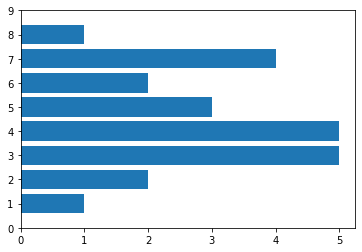

<class 'matplotlib.axes._subplots.AxesSubplot'>


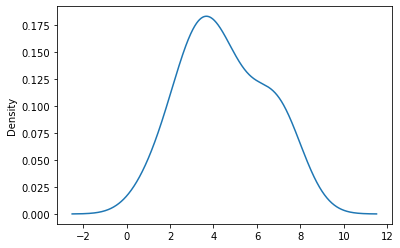

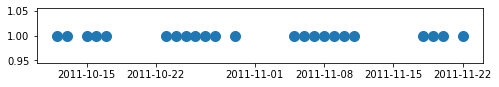

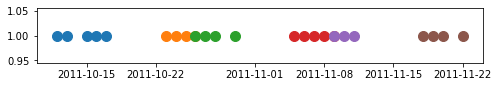

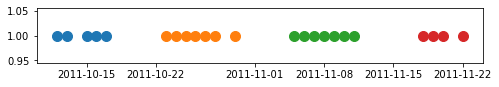

In [2]:
#export
import matplotlib.pyplot as plt
import math
import pandas as pd
import gamba as gb
import datetime
from datetime import timedelta

def plot_continuous_time_domain(player_bets):
    
    plt.figure(figsize=[8,1])
    plt.scatter(player_bets['bet_time'].values, [1 for x in player_bets['bet_time']], s=100)
    
    return plt
    
def discretise_player_bets(player_bets, days=7):
    
    days_betting = player_bets['bet_time'].max() - player_bets['bet_time'].min()
    
    window_starts = [player_bets['bet_time'].min() + timedelta(days=days * x) for x in range(math.ceil(days_betting.days / days + 1))]
    
    discrete_blocks = [player_bets[player_bets['bet_time'].between(start, start + timedelta(days=days))] for start in window_starts]
    
    return discrete_blocks

def plot_discrete_time_domain(player_bets, days=7):
    days_betting = player_bets['bet_time'].max() - player_bets['bet_time'].min()
    
    window_starts = [player_bets['bet_time'].min() + timedelta(days=days * x) for x in range(math.ceil(days_betting.days / days + 1))]
    
    discrete_blocks = discretise_player_bets(player_bets)
    
    plt.figure(figsize=[8,1])
    for block in discrete_blocks:
        plt.scatter(block['bet_time'].values, [1 for x in block['bet_time']], s=100)
        
    return plt
    
def plot_session_domain(player_bets, session_window=30):
    
    sessions = get_sessions(player_bets, session_window=session_window)
    
    plt.figure(figsize=[8,1])
    for session in sessions:
        plt.scatter(session['bet_time'].values, [1 for x in session['bet_time']], s=100)
    
    return plt
    
def plot_cost_domain(player_bets):
    
    bar_y = sorted(player_bets['bet_size'].unique())
    bar_x = [len(player_bets[player_bets['bet_size'] == size]) for size in bar_y]
    
    plt.figure()
    plt.barh(bar_y, bar_x)
    plt.ylim(min(bar_y) - 1, max(bar_y) + 1)
    
    plt.show()
    
    plot = player_bets['bet_size'].plot.kde()
    print(type(plot))
    
def show_domain_differences():
    start = datetime.datetime.strptime('10/10/11', "%m/%d/%y")
    player_bets = pd.DataFrame()
    bet_times = [2,3,5,6,7, 13,14,15,16,17,18,20, 26,27,28,29,30,31,32, 39,40,41,43]
    bet_days = [start + timedelta(days=x) for x in bet_times]
    bet_sizes = [2,2,3,3,1,5,4,5,3,3,4,5,7,6,8,7,7,6,7,4,4,3,4]

    player_bets['bet_time'] = bet_days
    player_bets['bet_size'] = bet_sizes
    
    plot_cost_domain(player_bets)

    plot_continuous_time_domain(player_bets)

    plot_discrete_time_domain(player_bets)

    plot_session_domain(player_bets, session_window=60*48)
    
#show_domain_differences()

## References

{% bibliography --cited %}